OpenClassrooms
Project 4, Data Scientist
Author : Oumeima EL GHARBI
Date : August,September 2022

# Feature Engineering to predict Energies

### Introduction

This feature engineering notebook produces three train/test dataset to predict :
- Log-SiteEnergyUseWN(kBtu)
- Log-TotalGHGEmissions
- Log-TotalGHGEmissions using the ENERGYSTARScore as a feature

#### Importing libraries

In [370]:
%reset -f

import pickle

import warnings
warnings.filterwarnings(action="ignore")

from exploration import *

from sklearn. model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

%matplotlib inline
%autosave 300

Autosaving every 300 seconds


In [371]:
# Heure démarrage
t0 = time()

# seed pour les générateurs aléatoires
seed = 1
print("Seed value: ", seed)

Seed value:  1


#### Loading dataset

In [372]:
global columns_to_categorize
columns_to_categorize = ["BuildingType", "PrimaryPropertyType", "Neighborhood"]
category_types = {column: 'object' for column in columns_to_categorize}

path = "./dataset/cleaned/"
filename = "data_exploration.csv"
dataset_path = "{}{}".format(path, filename)
# we assign the categorical features with a categotical type

dataset = pd.read_csv(dataset_path, encoding='utf-8', dtype=category_types)

In [373]:
dataset.shape

(1508, 13)

In [374]:
dataset.dtypes

Neighborhood                            object
BuildingType                            object
PrimaryPropertyType                     object
ENERGYSTARScore                        float64
YearSinceBuilt                           int64
Log-NumberofFloors                     float64
Log-PropertyGFATotal                   float64
Log-PropertyGFABuilding(s)             float64
Log-LargestPropertyUseTypeGFA          float64
Log-SecondLargestPropertyUseTypeGFA    float64
Log-ThirdLargestPropertyUseTypeGFA     float64
Log-SiteEnergyUseWN(kBtu)              float64
Log-TotalGHGEmissions                  float64
dtype: object

In [375]:
dataset.columns

Index(['Neighborhood', 'BuildingType', 'PrimaryPropertyType',
       'ENERGYSTARScore', 'YearSinceBuilt', 'Log-NumberofFloors',
       'Log-PropertyGFATotal', 'Log-PropertyGFABuilding(s)',
       'Log-LargestPropertyUseTypeGFA', 'Log-SecondLargestPropertyUseTypeGFA',
       'Log-ThirdLargestPropertyUseTypeGFA', 'Log-SiteEnergyUseWN(kBtu)',
       'Log-TotalGHGEmissions'],
      dtype='object')

### 1) Separation common train and test dataset

#### Separation features : vectors / target

In [376]:
models_targets = ["Log-SiteEnergyUseWN(kBtu)", "Log-TotalGHGEmissions"]

In [377]:
# List of variables / features for the predicition and the target
models_energy_target = ["Log-SiteEnergyUseWN(kBtu)"]
models_energy_features = [feature for feature in dataset.columns if feature not in ['ENERGYSTARScore', *models_energy_target, *models_targets]]

models_energy = models_energy_features + models_energy_target

print(models_energy_features, end="\n\n")
print(models_energy_target, end="\n\n")

print("Verification :", len(models_energy_features) + len(models_energy_target) == len(models_energy))

['Neighborhood', 'BuildingType', 'PrimaryPropertyType', 'YearSinceBuilt', 'Log-NumberofFloors', 'Log-PropertyGFATotal', 'Log-PropertyGFABuilding(s)', 'Log-LargestPropertyUseTypeGFA', 'Log-SecondLargestPropertyUseTypeGFA', 'Log-ThirdLargestPropertyUseTypeGFA']

['Log-SiteEnergyUseWN(kBtu)']

Verification : True


In [378]:
# List of variables / features for the predicition and the target
models_CO2_target = ["Log-TotalGHGEmissions"]
models_CO2_features = [feature for feature in dataset.columns if feature not in ['ENERGYSTARScore', *models_energy_target, *models_targets]]

models_CO2 = models_CO2_features + models_CO2_target

print(models_CO2_features, end="\n\n")
print(models_CO2_target, end="\n\n")

print("Verification :", len(models_CO2_features) + len(models_CO2_target) == len(models_CO2))

['Neighborhood', 'BuildingType', 'PrimaryPropertyType', 'YearSinceBuilt', 'Log-NumberofFloors', 'Log-PropertyGFATotal', 'Log-PropertyGFABuilding(s)', 'Log-LargestPropertyUseTypeGFA', 'Log-SecondLargestPropertyUseTypeGFA', 'Log-ThirdLargestPropertyUseTypeGFA']

['Log-TotalGHGEmissions']

Verification : True


In [379]:
# List of variables / features for the predicition and the target
models_ENERGYSTARScore_target = ["Log-TotalGHGEmissions"]
models_ENERGYSTARScore_features = [feature for feature in dataset.columns if feature not in [*models_energy_target, *models_targets]]

models_ENERGYSTARScore = models_ENERGYSTARScore_features + models_ENERGYSTARScore_target

print(models_ENERGYSTARScore_features, end="\n\n")
print(models_ENERGYSTARScore_target, end="\n\n")

print("Verification :", len(models_ENERGYSTARScore_features) + len(models_ENERGYSTARScore_target) == len(models_ENERGYSTARScore))

['Neighborhood', 'BuildingType', 'PrimaryPropertyType', 'ENERGYSTARScore', 'YearSinceBuilt', 'Log-NumberofFloors', 'Log-PropertyGFATotal', 'Log-PropertyGFABuilding(s)', 'Log-LargestPropertyUseTypeGFA', 'Log-SecondLargestPropertyUseTypeGFA', 'Log-ThirdLargestPropertyUseTypeGFA']

['Log-TotalGHGEmissions']

Verification : True


#### Train / Test Split

##### Energy and CO2

In [380]:
# We create a training set and a test set (the test set contains 30% of the dataset)
train_common, test_common = train_test_split(dataset, test_size=0.3,  random_state=seed)

In [381]:
train_common.shape

(1055, 13)

In [382]:
test_common.shape

(453, 13)

##### ENERGYSTARScore

In [383]:
# we drop the buildings for which the EnergyStarScore is missing
dataset_clean = dataset.dropna(axis=0)
train_clean, test_clean = train_test_split(dataset_clean, test_size=0.3, random_state=seed)

In [384]:
train_clean.shape

(689, 13)

In [385]:
test_clean.shape

(296, 13)

### Selecting train/test set for Energy, CO2 and ENERGYSTARScore

In [386]:
train_energy, test_energy = train_common[models_energy], test_common[models_energy]
train_CO2, test_CO2 = train_common[models_CO2], test_common[models_CO2]
train_ENERGYSTARScore, test_ENERGYSTARScore = train_clean[models_ENERGYSTARScore], test_clean[models_ENERGYSTARScore]

In [387]:
train_energy

,Neighborhood,BuildingType,PrimaryPropertyType,YearSinceBuilt,Log-NumberofFloors,Log-PropertyGFATotal,Log-PropertyGFABuilding(s),Log-LargestPropertyUseTypeGFA,Log-SecondLargestPropertyUseTypeGFA,Log-ThirdLargestPropertyUseTypeGFA,Log-SiteEnergyUseWN(kBtu)
1342,Ballard,Nonresidential cos,Other,72,1.098612,10.289362,10.289362,9.824985,9.099074,7.276556,14.412538
1469,Downtown,Nonresidential,Small- and mid-sized office,9,1.386294,11.045526,10.772141,10.757924,0.000000,0.000000,14.781239
1404,Magnolia / queen anne,Nonresidential,Worship facility,69,1.098612,10.367410,10.367410,10.367410,0.000000,0.000000,14.451485
1153,Delridge,Nonresidential cos,Other,47,1.098612,10.212001,10.212001,10.277290,9.048880,6.573680,15.962189
614,Downtown,Nonresidential,Retail store,91,1.098612,10.176221,10.176221,10.176221,0.000000,0.000000,14.326921
...,...,...,...,...,...,...,...,...,...,...,...
715,Lake union,Nonresidential,Large office,37,1.791759,11.833116,11.317336,11.261858,10.924228,8.398184,15.393115
905,Ballard,Nonresidential,Warehouse,42,0.693147,10.592652,10.592652,10.592652,0.000000,0.000000,13.559793
1096,Greater duwamish,Nonresidential,Warehouse,52,0.693147,10.678007,10.678007,10.503175,8.848078,0.000000,13.187671
235,Downtown,Nonresidential,Large office,33,4.043051,14.288995,14.010846,14.088949,12.873546,10.333483,17.747032


In [388]:
train_CO2

,Neighborhood,BuildingType,PrimaryPropertyType,YearSinceBuilt,Log-NumberofFloors,Log-PropertyGFATotal,Log-PropertyGFABuilding(s),Log-LargestPropertyUseTypeGFA,Log-SecondLargestPropertyUseTypeGFA,Log-ThirdLargestPropertyUseTypeGFA,Log-TotalGHGEmissions
1342,Ballard,Nonresidential cos,Other,72,1.098612,10.289362,10.289362,9.824985,9.099074,7.276556,4.047428
1469,Downtown,Nonresidential,Small- and mid-sized office,9,1.386294,11.045526,10.772141,10.757924,0.000000,0.000000,3.049273
1404,Magnolia / queen anne,Nonresidential,Worship facility,69,1.098612,10.367410,10.367410,10.367410,0.000000,0.000000,4.239743
1153,Delridge,Nonresidential cos,Other,47,1.098612,10.212001,10.212001,10.277290,9.048880,6.573680,5.662578
614,Downtown,Nonresidential,Retail store,91,1.098612,10.176221,10.176221,10.176221,0.000000,0.000000,3.549043
...,...,...,...,...,...,...,...,...,...,...,...
715,Lake union,Nonresidential,Large office,37,1.791759,11.833116,11.317336,11.261858,10.924228,8.398184,3.520461
905,Ballard,Nonresidential,Warehouse,42,0.693147,10.592652,10.592652,10.592652,0.000000,0.000000,1.830980
1096,Greater duwamish,Nonresidential,Warehouse,52,0.693147,10.678007,10.678007,10.503175,8.848078,0.000000,1.551809
235,Downtown,Nonresidential,Large office,33,4.043051,14.288995,14.010846,14.088949,12.873546,10.333483,6.266783


In [389]:
train_ENERGYSTARScore

,Neighborhood,BuildingType,PrimaryPropertyType,ENERGYSTARScore,YearSinceBuilt,Log-NumberofFloors,Log-PropertyGFATotal,Log-PropertyGFABuilding(s),Log-LargestPropertyUseTypeGFA,Log-SecondLargestPropertyUseTypeGFA,Log-ThirdLargestPropertyUseTypeGFA,Log-TotalGHGEmissions
1340,Central,Nonresidential,K-12 school,40.0,97,1.098612,10.014358,10.014358,10.014358,0.000000,0.0,4.029450
949,North,Nonresidential,Senior care community,4.0,24,1.791759,10.684233,10.684233,10.684233,0.000000,0.0,4.425685
899,Ballard,Nonresidential,K-12 school,97.0,100,1.386294,10.475850,10.475850,10.475850,0.000000,0.0,4.116432
1171,Greater duwamish,Nonresidential,Retail store,69.0,58,0.693147,10.525354,10.525354,10.525354,0.000000,0.0,4.083621
1055,Southeast,Nonresidential,Worship facility,96.0,41,1.386294,10.038718,10.038718,10.038718,0.000000,0.0,2.633327
...,...,...,...,...,...,...,...,...,...,...,...,...
1125,Greater duwamish,Nonresidential,Warehouse,15.0,52,0.693147,10.691968,10.691968,10.724368,0.000000,0.0,5.173491
109,Lake union,Nonresidential,Hotel,79.0,24,1.791759,11.727400,11.450209,11.727400,10.308986,0.0,5.738506
1377,Northwest,Nonresidential,Small- and mid-sized office,87.0,39,1.386294,10.114437,9.819943,9.819943,8.748464,0.0,1.677097
322,Magnolia / queen anne,Nonresidential,Warehouse,94.0,25,1.609438,11.571591,11.571591,11.571591,0.000000,0.0,3.280159


### 2) Normalization

In [390]:
print("We separate categorical variables from numerical variables.")

We separate categorical variables from numerical variables.


##### Energy and CO2

In [391]:
dataset.select_dtypes('object') # we don't have 'object' here but it is just in case.

categorical_columns = dataset.select_dtypes('object').columns
numerical_columns_energy_CO2 = dataset[models_energy_features].select_dtypes(include='number').columns
#numerical_columns = X.select_dtypes(include='number').columns

print("Shape of categorical variables : ", categorical_columns.shape)
print("Shape of numerical variables :", numerical_columns_energy_CO2.shape)

Shape of categorical variables :  (3,)
Shape of numerical variables : (7,)


##### ENERGYSTARScore

In [392]:
dataset.select_dtypes('object') # we don't have 'object' here but it is just in case.

categorical_columns = dataset.select_dtypes('object').columns
numerical_columns_ENERGYSTARScore = dataset[models_ENERGYSTARScore_features].select_dtypes(include='number').columns

print("Shape of categorical variables : ", categorical_columns.shape)
print("Shape of numerical variables :", numerical_columns_ENERGYSTARScore.shape)

Shape of categorical variables :  (3,)
Shape of numerical variables : (8,)


#### 1) Data Standardisation

We have to standardize the variables before learning a **Ridge Regression**.
Standardizing means that each variable will have a **standard deviation** equal to 1.

##### Energy

In [393]:
print("Numerical variables standardization")
print("We have :", numerical_columns_energy_CO2.shape[0], "numerical features to standardize.",end="\n\n")

print(numerical_columns_energy_CO2)

Numerical variables standardization
We have : 7 numerical features to standardize.

Index(['YearSinceBuilt', 'Log-NumberofFloors', 'Log-PropertyGFATotal',
       'Log-PropertyGFABuilding(s)', 'Log-LargestPropertyUseTypeGFA',
       'Log-SecondLargestPropertyUseTypeGFA',
       'Log-ThirdLargestPropertyUseTypeGFA'],
      dtype='object')


In [394]:
# We train / fit the scaler on the training set / Computes the mean and std to be used for later scaling.
std_scaler_energy = StandardScaler().fit(train_energy[numerical_columns_energy_CO2])
# We transform the training set and the testing set / Performs standardization by centering and scaling.
train_energy_std, test_energy_std = train_energy.copy(), test_energy.copy()

train_energy_std[numerical_columns_energy_CO2] = std_scaler_energy.transform(train_energy[numerical_columns_energy_CO2])
test_energy_std[numerical_columns_energy_CO2] = std_scaler_energy.transform(test_energy[numerical_columns_energy_CO2])

print("Before")
display(train_energy)
print("After")
display(train_energy_std)

Before


,Neighborhood,BuildingType,PrimaryPropertyType,YearSinceBuilt,Log-NumberofFloors,Log-PropertyGFATotal,Log-PropertyGFABuilding(s),Log-LargestPropertyUseTypeGFA,Log-SecondLargestPropertyUseTypeGFA,Log-ThirdLargestPropertyUseTypeGFA,Log-SiteEnergyUseWN(kBtu)
1342,Ballard,Nonresidential cos,Other,72,1.098612,10.289362,10.289362,9.824985,9.099074,7.276556,14.412538
1469,Downtown,Nonresidential,Small- and mid-sized office,9,1.386294,11.045526,10.772141,10.757924,0.000000,0.000000,14.781239
1404,Magnolia / queen anne,Nonresidential,Worship facility,69,1.098612,10.367410,10.367410,10.367410,0.000000,0.000000,14.451485
1153,Delridge,Nonresidential cos,Other,47,1.098612,10.212001,10.212001,10.277290,9.048880,6.573680,15.962189
614,Downtown,Nonresidential,Retail store,91,1.098612,10.176221,10.176221,10.176221,0.000000,0.000000,14.326921
...,...,...,...,...,...,...,...,...,...,...,...
715,Lake union,Nonresidential,Large office,37,1.791759,11.833116,11.317336,11.261858,10.924228,8.398184,15.393115
905,Ballard,Nonresidential,Warehouse,42,0.693147,10.592652,10.592652,10.592652,0.000000,0.000000,13.559793
1096,Greater duwamish,Nonresidential,Warehouse,52,0.693147,10.678007,10.678007,10.503175,8.848078,0.000000,13.187671
235,Downtown,Nonresidential,Large office,33,4.043051,14.288995,14.010846,14.088949,12.873546,10.333483,17.747032


After


,Neighborhood,BuildingType,PrimaryPropertyType,YearSinceBuilt,Log-NumberofFloors,Log-PropertyGFATotal,Log-PropertyGFABuilding(s),Log-LargestPropertyUseTypeGFA,Log-SecondLargestPropertyUseTypeGFA,Log-ThirdLargestPropertyUseTypeGFA,Log-SiteEnergyUseWN(kBtu)
1342,Ballard,Nonresidential cos,Other,0.315072,-0.408384,-0.794892,-0.742562,-1.079001,0.880533,1.518515,14.412538
1469,Downtown,Nonresidential,Small- and mid-sized office,-1.587298,0.022755,0.012898,-0.198878,-0.082539,-0.959144,-0.506127,14.781239
1404,Magnolia / queen anne,Nonresidential,Worship facility,0.224483,-0.408384,-0.711515,-0.654668,-0.499643,-0.959144,-0.506127,14.451485
1153,Delridge,Nonresidential cos,Other,-0.439836,-0.408384,-0.877534,-0.829683,-0.595899,0.870385,1.322946,15.962189
614,Downtown,Nonresidential,Retail store,0.888803,-0.408384,-0.915757,-0.869977,-0.703850,-0.959144,-0.506127,14.326921
...,...,...,...,...,...,...,...,...,...,...,...
715,Lake union,Nonresidential,Large office,-0.741800,0.630411,0.854258,0.415096,0.455708,1.249548,1.830599,15.393115
905,Ballard,Nonresidential,Warehouse,-0.590818,-1.016040,-0.470896,-0.401011,-0.259065,-0.959144,-0.506127,13.559793
1096,Greater duwamish,Nonresidential,Warehouse,-0.288855,-1.016040,-0.379713,-0.304888,-0.354634,0.829786,-0.506127,13.187671
235,Downtown,Nonresidential,Large office,-0.862585,4.004341,3.477806,3.448405,3.475293,1.643667,2.369080,17.747032


##### CO2

In [395]:
# We train / fit the scaler on the training set / Computes the mean and std to be used for later scaling.
std_scaler_CO2 = StandardScaler().fit(train_CO2[numerical_columns_energy_CO2])
# We transform the training set and the testing set / Performs standardization by centering and scaling.
train_CO2_std, test_CO2_std = train_CO2.copy(), test_CO2.copy()

train_CO2_std[numerical_columns_energy_CO2] = std_scaler_CO2.transform(train_CO2[numerical_columns_energy_CO2])
test_CO2_std[numerical_columns_energy_CO2] = std_scaler_CO2.transform(test_CO2[numerical_columns_energy_CO2])

print("Before")
display(train_CO2)
print("After")
display(train_CO2_std)

Before


,Neighborhood,BuildingType,PrimaryPropertyType,YearSinceBuilt,Log-NumberofFloors,Log-PropertyGFATotal,Log-PropertyGFABuilding(s),Log-LargestPropertyUseTypeGFA,Log-SecondLargestPropertyUseTypeGFA,Log-ThirdLargestPropertyUseTypeGFA,Log-TotalGHGEmissions
1342,Ballard,Nonresidential cos,Other,72,1.098612,10.289362,10.289362,9.824985,9.099074,7.276556,4.047428
1469,Downtown,Nonresidential,Small- and mid-sized office,9,1.386294,11.045526,10.772141,10.757924,0.000000,0.000000,3.049273
1404,Magnolia / queen anne,Nonresidential,Worship facility,69,1.098612,10.367410,10.367410,10.367410,0.000000,0.000000,4.239743
1153,Delridge,Nonresidential cos,Other,47,1.098612,10.212001,10.212001,10.277290,9.048880,6.573680,5.662578
614,Downtown,Nonresidential,Retail store,91,1.098612,10.176221,10.176221,10.176221,0.000000,0.000000,3.549043
...,...,...,...,...,...,...,...,...,...,...,...
715,Lake union,Nonresidential,Large office,37,1.791759,11.833116,11.317336,11.261858,10.924228,8.398184,3.520461
905,Ballard,Nonresidential,Warehouse,42,0.693147,10.592652,10.592652,10.592652,0.000000,0.000000,1.830980
1096,Greater duwamish,Nonresidential,Warehouse,52,0.693147,10.678007,10.678007,10.503175,8.848078,0.000000,1.551809
235,Downtown,Nonresidential,Large office,33,4.043051,14.288995,14.010846,14.088949,12.873546,10.333483,6.266783


After


,Neighborhood,BuildingType,PrimaryPropertyType,YearSinceBuilt,Log-NumberofFloors,Log-PropertyGFATotal,Log-PropertyGFABuilding(s),Log-LargestPropertyUseTypeGFA,Log-SecondLargestPropertyUseTypeGFA,Log-ThirdLargestPropertyUseTypeGFA,Log-TotalGHGEmissions
1342,Ballard,Nonresidential cos,Other,0.315072,-0.408384,-0.794892,-0.742562,-1.079001,0.880533,1.518515,4.047428
1469,Downtown,Nonresidential,Small- and mid-sized office,-1.587298,0.022755,0.012898,-0.198878,-0.082539,-0.959144,-0.506127,3.049273
1404,Magnolia / queen anne,Nonresidential,Worship facility,0.224483,-0.408384,-0.711515,-0.654668,-0.499643,-0.959144,-0.506127,4.239743
1153,Delridge,Nonresidential cos,Other,-0.439836,-0.408384,-0.877534,-0.829683,-0.595899,0.870385,1.322946,5.662578
614,Downtown,Nonresidential,Retail store,0.888803,-0.408384,-0.915757,-0.869977,-0.703850,-0.959144,-0.506127,3.549043
...,...,...,...,...,...,...,...,...,...,...,...
715,Lake union,Nonresidential,Large office,-0.741800,0.630411,0.854258,0.415096,0.455708,1.249548,1.830599,3.520461
905,Ballard,Nonresidential,Warehouse,-0.590818,-1.016040,-0.470896,-0.401011,-0.259065,-0.959144,-0.506127,1.830980
1096,Greater duwamish,Nonresidential,Warehouse,-0.288855,-1.016040,-0.379713,-0.304888,-0.354634,0.829786,-0.506127,1.551809
235,Downtown,Nonresidential,Large office,-0.862585,4.004341,3.477806,3.448405,3.475293,1.643667,2.369080,6.266783


##### ENERGYSTARScore

In [396]:
print("Shape of categorical variables : ", categorical_columns.shape)
print("Shape of numerical variables :", numerical_columns_ENERGYSTARScore.shape)


print("Numerical variables standardization")
print("We have :", numerical_columns_ENERGYSTARScore.shape[0], "numerical features to standardize.",end="\n\n")

print(numerical_columns_ENERGYSTARScore)


# We train / fit the scaler on the training set / Computes the mean and std to be used for later scaling.
std_scaler_ENERGYSTARScore = StandardScaler().fit(train_ENERGYSTARScore[numerical_columns_ENERGYSTARScore])
# We transform the training set and the testing set / Performs standardization by centering and scaling.
train_ENERGYSTARScore_std, test_ENERGYSTARScore_std = train_ENERGYSTARScore.copy(), test_ENERGYSTARScore.copy()

train_ENERGYSTARScore_std[numerical_columns_ENERGYSTARScore] = std_scaler_ENERGYSTARScore.transform(train_ENERGYSTARScore[numerical_columns_ENERGYSTARScore])
test_ENERGYSTARScore_std[numerical_columns_ENERGYSTARScore] = std_scaler_ENERGYSTARScore.transform(test_ENERGYSTARScore[numerical_columns_ENERGYSTARScore])

print("Before")
display(train_ENERGYSTARScore)
print("After")
display(train_ENERGYSTARScore_std)

Shape of categorical variables :  (3,)
Shape of numerical variables : (8,)
Numerical variables standardization
We have : 8 numerical features to standardize.

Index(['ENERGYSTARScore', 'YearSinceBuilt', 'Log-NumberofFloors',
       'Log-PropertyGFATotal', 'Log-PropertyGFABuilding(s)',
       'Log-LargestPropertyUseTypeGFA', 'Log-SecondLargestPropertyUseTypeGFA',
       'Log-ThirdLargestPropertyUseTypeGFA'],
      dtype='object')
Before


,Neighborhood,BuildingType,PrimaryPropertyType,ENERGYSTARScore,YearSinceBuilt,Log-NumberofFloors,Log-PropertyGFATotal,Log-PropertyGFABuilding(s),Log-LargestPropertyUseTypeGFA,Log-SecondLargestPropertyUseTypeGFA,Log-ThirdLargestPropertyUseTypeGFA,Log-TotalGHGEmissions
1340,Central,Nonresidential,K-12 school,40.0,97,1.098612,10.014358,10.014358,10.014358,0.000000,0.0,4.029450
949,North,Nonresidential,Senior care community,4.0,24,1.791759,10.684233,10.684233,10.684233,0.000000,0.0,4.425685
899,Ballard,Nonresidential,K-12 school,97.0,100,1.386294,10.475850,10.475850,10.475850,0.000000,0.0,4.116432
1171,Greater duwamish,Nonresidential,Retail store,69.0,58,0.693147,10.525354,10.525354,10.525354,0.000000,0.0,4.083621
1055,Southeast,Nonresidential,Worship facility,96.0,41,1.386294,10.038718,10.038718,10.038718,0.000000,0.0,2.633327
...,...,...,...,...,...,...,...,...,...,...,...,...
1125,Greater duwamish,Nonresidential,Warehouse,15.0,52,0.693147,10.691968,10.691968,10.724368,0.000000,0.0,5.173491
109,Lake union,Nonresidential,Hotel,79.0,24,1.791759,11.727400,11.450209,11.727400,10.308986,0.0,5.738506
1377,Northwest,Nonresidential,Small- and mid-sized office,87.0,39,1.386294,10.114437,9.819943,9.819943,8.748464,0.0,1.677097
322,Magnolia / queen anne,Nonresidential,Warehouse,94.0,25,1.609438,11.571591,11.571591,11.571591,0.000000,0.0,3.280159


After


,Neighborhood,BuildingType,PrimaryPropertyType,ENERGYSTARScore,YearSinceBuilt,Log-NumberofFloors,Log-PropertyGFATotal,Log-PropertyGFABuilding(s),Log-LargestPropertyUseTypeGFA,Log-SecondLargestPropertyUseTypeGFA,Log-ThirdLargestPropertyUseTypeGFA,Log-TotalGHGEmissions
1340,Central,Nonresidential,K-12 school,-0.839496,1.200737,-0.461980,-1.161728,-1.121725,-1.041168,-0.876198,-0.412006,4.029450
949,North,Nonresidential,Senior care community,-2.098130,-1.098215,0.478284,-0.479293,-0.404803,-0.330035,-0.876198,-0.412006,4.425685
899,Ballard,Nonresidential,K-12 school,1.153342,1.295214,-0.071735,-0.691583,-0.627821,-0.551253,-0.876198,-0.412006,4.116432
1171,Greater duwamish,Nonresidential,Retail store,0.174404,-0.027470,-1.012000,-0.641152,-0.574841,-0.498700,-0.876198,-0.412006,4.083621
1055,Southeast,Nonresidential,Worship facility,1.118380,-0.562843,-0.071735,-1.136912,-1.095654,-1.015308,-0.876198,-0.412006,2.633327
...,...,...,...,...,...,...,...,...,...,...,...,...
1125,Greater duwamish,Nonresidential,Warehouse,-1.713548,-0.216425,-1.012000,-0.471414,-0.396525,-0.287429,-0.876198,-0.412006,5.173491
109,Lake union,Nonresidential,Hotel,0.524025,-1.098215,0.478284,0.583432,0.414969,0.777379,1.161971,-0.412006,5.738506
1377,Northwest,Nonresidential,Small- and mid-sized office,0.803722,-0.625827,-0.071735,-1.059773,-1.329794,-1.247557,0.853443,-0.412006,1.677097
322,Magnolia / queen anne,Nonresidential,Warehouse,1.048456,-1.066722,0.230962,0.424701,0.544875,0.611973,-0.876198,-0.412006,3.280159


#### 2) Feature Encoding : One Hot Encoder

##### Energy

In [397]:
print("Categorical variables featuring")

print("We have :", categorical_columns.shape[0], "categorical features to encode.", end="\n\n")
print(categorical_columns)

Categorical variables featuring
We have : 3 categorical features to encode.

Index(['Neighborhood', 'BuildingType', 'PrimaryPropertyType'], dtype='object')


In [398]:
train_energy.dtypes # we check that we have categories

Neighborhood                            object
BuildingType                            object
PrimaryPropertyType                     object
YearSinceBuilt                           int64
Log-NumberofFloors                     float64
Log-PropertyGFATotal                   float64
Log-PropertyGFABuilding(s)             float64
Log-LargestPropertyUseTypeGFA          float64
Log-SecondLargestPropertyUseTypeGFA    float64
Log-ThirdLargestPropertyUseTypeGFA     float64
Log-SiteEnergyUseWN(kBtu)              float64
dtype: object

In [399]:
train_energy[categorical_columns].nunique()

Neighborhood           13
BuildingType            4
PrimaryPropertyType    21
dtype: int64

In [400]:
train_energy_std[categorical_columns]

,Neighborhood,BuildingType,PrimaryPropertyType
1342,Ballard,Nonresidential cos,Other
1469,Downtown,Nonresidential,Small- and mid-sized office
1404,Magnolia / queen anne,Nonresidential,Worship facility
1153,Delridge,Nonresidential cos,Other
614,Downtown,Nonresidential,Retail store
...,...,...,...
715,Lake union,Nonresidential,Large office
905,Ballard,Nonresidential,Warehouse
1096,Greater duwamish,Nonresidential,Warehouse
235,Downtown,Nonresidential,Large office


##### Encoding the categorical features of the train set


In [401]:
print("Now, we can use the One Hot Encoder.")
print("With the one hot encoder, we will get :", sum([train_energy[categorical_columns].nunique()[i] for i in range(len(categorical_columns))]), "columns to encodes the categorical features.")

Now, we can use the One Hot Encoder.
With the one hot encoder, we will get : 38 columns to encodes the categorical features.


In [402]:
# 0) creating instance of one-hot-encoder
one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False) # if sparse=True (by default), we need to add .toarray() to encoded_categorical_data

# 1) Fit the encoder on the training set
one_hot_encoder.fit(train_energy_std[categorical_columns])

# 2) we get the encoded numpy array
encoded_categorical_data = one_hot_encoder.transform(train_energy_std[categorical_columns])

# 3) we make a list of the columns names
encoded_categorical_data_names = one_hot_encoder.get_feature_names_out().tolist()
print("We have indeed :", len(encoded_categorical_data_names), "labels after encoding the categorical variables.")

# 4) we recreate a dataframe with the column names and the numpy array
train_encoded = pd.DataFrame(columns=encoded_categorical_data_names,
                               data=encoded_categorical_data,
                               index=train_energy_std.index)
display(train_encoded.sort_index())

We have indeed : 38 labels after encoding the categorical variables.


,Neighborhood_Ballard,Neighborhood_Central,Neighborhood_Delridge,Neighborhood_Downtown,Neighborhood_East,Neighborhood_Greater duwamish,Neighborhood_Lake union,Neighborhood_Magnolia / queen anne,Neighborhood_North,Neighborhood_Northeast,...,PrimaryPropertyType_Residence hall,PrimaryPropertyType_Restaurant,PrimaryPropertyType_Retail store,PrimaryPropertyType_Self-storage facility,PrimaryPropertyType_Senior care community,PrimaryPropertyType_Small- and mid-sized office,PrimaryPropertyType_Supermarket / grocery store,PrimaryPropertyType_University,PrimaryPropertyType_Warehouse,PrimaryPropertyType_Worship facility
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1503,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1504,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1505,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1506,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [403]:
# 5) Concatenate the two dataframes for the training set

numerical_columns_energy_CO2.tolist()
features_to_merge = numerical_columns_energy_CO2.tolist().copy()
#features_to_merge.append("ENERGYSTARScore")
features_to_merge.extend(models_energy_target)
print(features_to_merge, end="\n\n")

# when merging, we put the categorical features first so that the targets will be at the end of the dataframe.
train_std_encoded = pd.merge(train_encoded.sort_index(), train_energy_std[features_to_merge].sort_index(), left_index=True, right_index=True)
display(train_std_encoded.sort_index())

['YearSinceBuilt', 'Log-NumberofFloors', 'Log-PropertyGFATotal', 'Log-PropertyGFABuilding(s)', 'Log-LargestPropertyUseTypeGFA', 'Log-SecondLargestPropertyUseTypeGFA', 'Log-ThirdLargestPropertyUseTypeGFA', 'Log-SiteEnergyUseWN(kBtu)']



,Neighborhood_Ballard,Neighborhood_Central,Neighborhood_Delridge,Neighborhood_Downtown,Neighborhood_East,Neighborhood_Greater duwamish,Neighborhood_Lake union,Neighborhood_Magnolia / queen anne,Neighborhood_North,Neighborhood_Northeast,...,PrimaryPropertyType_Warehouse,PrimaryPropertyType_Worship facility,YearSinceBuilt,Log-NumberofFloors,Log-PropertyGFATotal,Log-PropertyGFABuilding(s),Log-LargestPropertyUseTypeGFA,Log-SecondLargestPropertyUseTypeGFA,Log-ThirdLargestPropertyUseTypeGFA,Log-SiteEnergyUseWN(kBtu)
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.009588,1.789163,0.380914,0.496952,0.592599,-0.959144,-0.506127,15.824652
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-1.073960,1.669206,0.549649,0.497818,0.536131,0.985881,1.841900,15.974742
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-0.258658,3.546677,2.924050,2.918469,2.885175,-0.959144,-0.506127,18.118725
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-0.590818,2.357891,1.113570,0.778771,0.948845,1.290628,-0.506127,16.500395
5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-1.164549,-0.408384,0.482847,0.061798,0.597371,-0.959144,-0.506127,16.347755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1503,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.949196,-0.408384,-0.969118,-0.926228,-0.757201,-0.959144,-0.506127,15.369819
1504,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,-1.587298,-1.016040,0.161290,0.265429,0.373013,-0.959144,-0.506127,14.978305
1505,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-1.647690,0.022755,-0.340793,-0.263859,-0.111843,-0.959144,-0.506127,14.150370
1506,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,-1.647690,0.861431,1.836029,1.712552,1.167740,1.381303,2.648748,17.530998


##### Encoding the categorical features of the test set

In [404]:
# 5) One Hot Encoding on the testing set

# 5.1) we get the encoded numpy array
TEST_encoded_categorical_data = one_hot_encoder.transform(test_energy_std[categorical_columns])

# 5.2) we recreate a dataframe with the column names and the numpy array
test_encoded = pd.DataFrame(columns=encoded_categorical_data_names,
                               data=TEST_encoded_categorical_data,
                               index=test_energy_std.index)
display(test_encoded.sort_index())

# when merging, we put the categorical features first so that the targets will be at the end of the dataframe.
test_std_encoded = pd.merge(test_encoded.sort_index(), test_energy_std[features_to_merge].sort_index(), left_index=True, right_index=True)
display(test_std_encoded.sort_index())

,Neighborhood_Ballard,Neighborhood_Central,Neighborhood_Delridge,Neighborhood_Downtown,Neighborhood_East,Neighborhood_Greater duwamish,Neighborhood_Lake union,Neighborhood_Magnolia / queen anne,Neighborhood_North,Neighborhood_Northeast,...,PrimaryPropertyType_Residence hall,PrimaryPropertyType_Restaurant,PrimaryPropertyType_Retail store,PrimaryPropertyType_Self-storage facility,PrimaryPropertyType_Senior care community,PrimaryPropertyType_Small- and mid-sized office,PrimaryPropertyType_Supermarket / grocery store,PrimaryPropertyType_University,PrimaryPropertyType_Warehouse,PrimaryPropertyType_Worship facility
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1493,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1494,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1495,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1498,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,Neighborhood_Ballard,Neighborhood_Central,Neighborhood_Delridge,Neighborhood_Downtown,Neighborhood_East,Neighborhood_Greater duwamish,Neighborhood_Lake union,Neighborhood_Magnolia / queen anne,Neighborhood_North,Neighborhood_Northeast,...,PrimaryPropertyType_Warehouse,PrimaryPropertyType_Worship facility,YearSinceBuilt,Log-NumberofFloors,Log-PropertyGFATotal,Log-PropertyGFABuilding(s),Log-LargestPropertyUseTypeGFA,Log-SecondLargestPropertyUseTypeGFA,Log-ThirdLargestPropertyUseTypeGFA,Log-SiteEnergyUseWN(kBtu)
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.039785,1.538805,-0.010229,0.084616,0.201523,-0.959144,-0.506127,15.753792
6,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.039785,1.669206,0.313272,0.425646,0.503446,-0.959144,-0.506127,15.617677
8,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.704105,2.100345,1.040580,1.192361,1.252152,-0.959144,-0.506127,16.468334
12,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-0.590818,3.229995,1.741173,1.704257,1.881187,1.257042,-0.506127,16.930134
19,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.341748,1.538805,2.314455,2.535258,2.519445,-0.959144,-0.506127,17.666149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1493,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-1.647690,0.630411,-0.524984,-0.458030,-0.717887,0.794111,1.872531,14.668518
1494,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,-1.647690,1.538805,2.260646,2.478534,2.089173,1.452774,1.439367,16.747278
1495,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-1.647690,2.003623,0.906298,1.050804,1.222540,-0.959144,-0.506127,15.528942
1498,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-1.647690,-0.408384,0.594788,0.722415,1.475750,1.384202,-0.506127,15.482976


In [405]:
print("We can start now the modelling to predict the feature wanted.")

display(train_std_encoded)
display(test_std_encoded)

We can start now the modelling to predict the feature wanted.


,Neighborhood_Ballard,Neighborhood_Central,Neighborhood_Delridge,Neighborhood_Downtown,Neighborhood_East,Neighborhood_Greater duwamish,Neighborhood_Lake union,Neighborhood_Magnolia / queen anne,Neighborhood_North,Neighborhood_Northeast,...,PrimaryPropertyType_Warehouse,PrimaryPropertyType_Worship facility,YearSinceBuilt,Log-NumberofFloors,Log-PropertyGFATotal,Log-PropertyGFABuilding(s),Log-LargestPropertyUseTypeGFA,Log-SecondLargestPropertyUseTypeGFA,Log-ThirdLargestPropertyUseTypeGFA,Log-SiteEnergyUseWN(kBtu)
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.009588,1.789163,0.380914,0.496952,0.592599,-0.959144,-0.506127,15.824652
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-1.073960,1.669206,0.549649,0.497818,0.536131,0.985881,1.841900,15.974742
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-0.258658,3.546677,2.924050,2.918469,2.885175,-0.959144,-0.506127,18.118725
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-0.590818,2.357891,1.113570,0.778771,0.948845,1.290628,-0.506127,16.500395
5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-1.164549,-0.408384,0.482847,0.061798,0.597371,-0.959144,-0.506127,16.347755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1503,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.949196,-0.408384,-0.969118,-0.926228,-0.757201,-0.959144,-0.506127,15.369819
1504,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,-1.587298,-1.016040,0.161290,0.265429,0.373013,-0.959144,-0.506127,14.978305
1505,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-1.647690,0.022755,-0.340793,-0.263859,-0.111843,-0.959144,-0.506127,14.150370
1506,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,-1.647690,0.861431,1.836029,1.712552,1.167740,1.381303,2.648748,17.530998


,Neighborhood_Ballard,Neighborhood_Central,Neighborhood_Delridge,Neighborhood_Downtown,Neighborhood_East,Neighborhood_Greater duwamish,Neighborhood_Lake union,Neighborhood_Magnolia / queen anne,Neighborhood_North,Neighborhood_Northeast,...,PrimaryPropertyType_Warehouse,PrimaryPropertyType_Worship facility,YearSinceBuilt,Log-NumberofFloors,Log-PropertyGFATotal,Log-PropertyGFABuilding(s),Log-LargestPropertyUseTypeGFA,Log-SecondLargestPropertyUseTypeGFA,Log-ThirdLargestPropertyUseTypeGFA,Log-SiteEnergyUseWN(kBtu)
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.039785,1.538805,-0.010229,0.084616,0.201523,-0.959144,-0.506127,15.753792
6,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.039785,1.669206,0.313272,0.425646,0.503446,-0.959144,-0.506127,15.617677
8,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.704105,2.100345,1.040580,1.192361,1.252152,-0.959144,-0.506127,16.468334
12,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-0.590818,3.229995,1.741173,1.704257,1.881187,1.257042,-0.506127,16.930134
19,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.341748,1.538805,2.314455,2.535258,2.519445,-0.959144,-0.506127,17.666149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1493,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-1.647690,0.630411,-0.524984,-0.458030,-0.717887,0.794111,1.872531,14.668518
1494,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,-1.647690,1.538805,2.260646,2.478534,2.089173,1.452774,1.439367,16.747278
1495,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-1.647690,2.003623,0.906298,1.050804,1.222540,-0.959144,-0.506127,15.528942
1498,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-1.647690,-0.408384,0.594788,0.722415,1.475750,1.384202,-0.506127,15.482976


In [406]:
print("We rename train_std_encoded to train_energy_preprocess the same for test_std_encoded.")
train_energy_preprocess = train_std_encoded.copy()
test_energy_preprocess = test_std_encoded.copy()

We rename train_std_encoded to train_energy_preprocess the same for test_std_encoded.


In [407]:
display(train_energy_preprocess)

,Neighborhood_Ballard,Neighborhood_Central,Neighborhood_Delridge,Neighborhood_Downtown,Neighborhood_East,Neighborhood_Greater duwamish,Neighborhood_Lake union,Neighborhood_Magnolia / queen anne,Neighborhood_North,Neighborhood_Northeast,...,PrimaryPropertyType_Warehouse,PrimaryPropertyType_Worship facility,YearSinceBuilt,Log-NumberofFloors,Log-PropertyGFATotal,Log-PropertyGFABuilding(s),Log-LargestPropertyUseTypeGFA,Log-SecondLargestPropertyUseTypeGFA,Log-ThirdLargestPropertyUseTypeGFA,Log-SiteEnergyUseWN(kBtu)
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.009588,1.789163,0.380914,0.496952,0.592599,-0.959144,-0.506127,15.824652
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-1.073960,1.669206,0.549649,0.497818,0.536131,0.985881,1.841900,15.974742
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-0.258658,3.546677,2.924050,2.918469,2.885175,-0.959144,-0.506127,18.118725
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-0.590818,2.357891,1.113570,0.778771,0.948845,1.290628,-0.506127,16.500395
5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-1.164549,-0.408384,0.482847,0.061798,0.597371,-0.959144,-0.506127,16.347755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1503,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.949196,-0.408384,-0.969118,-0.926228,-0.757201,-0.959144,-0.506127,15.369819
1504,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,-1.587298,-1.016040,0.161290,0.265429,0.373013,-0.959144,-0.506127,14.978305
1505,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-1.647690,0.022755,-0.340793,-0.263859,-0.111843,-0.959144,-0.506127,14.150370
1506,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,-1.647690,0.861431,1.836029,1.712552,1.167740,1.381303,2.648748,17.530998


##### CO2

In [408]:
print("Categorical variables featuring")

print("We have :", categorical_columns.shape[0], "categorical features to encode.", end="\n\n")
print(categorical_columns)

# 0) creating instance of one-hot-encoder
one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False) # if sparse=True (by default), we need to add .toarray() to encoded_categorical_data

# 1) Fit the encoder on the training set
one_hot_encoder.fit(train_CO2_std[categorical_columns])

# 2) we get the encoded numpy array
encoded_categorical_data = one_hot_encoder.transform(train_CO2_std[categorical_columns])

# 3) we make a list of the columns names
encoded_categorical_data_names = one_hot_encoder.get_feature_names_out().tolist()
print("We have indeed :", len(encoded_categorical_data_names), "labels after encoding the categorical variables.")

# 4) we recreate a dataframe with the column names and the numpy array
train_encoded = pd.DataFrame(columns=encoded_categorical_data_names,
                             data=encoded_categorical_data,
                             index=train_CO2_std.index)
display(train_encoded.sort_index())


# 5) Concatenate the two dataframes for the training set

numerical_columns_energy_CO2.tolist()
features_to_merge = numerical_columns_energy_CO2.tolist().copy()
features_to_merge.extend(models_CO2_target)
print(features_to_merge, end="\n\n")

# when merging, we put the categorical features first so that the targets will be at the end of the dataframe.
train_std_encoded = pd.merge(train_encoded.sort_index(), train_CO2_std[features_to_merge].sort_index(), left_index=True, right_index=True)
display(train_std_encoded.sort_index())


# 5) One Hot Encoding on the testing set

# 5.1) we get the encoded numpy array
TEST_encoded_categorical_data = one_hot_encoder.transform(test_CO2_std[categorical_columns])

# 5.2) we recreate a dataframe with the column names and the numpy array
test_encoded = pd.DataFrame(columns=encoded_categorical_data_names,
                            data=TEST_encoded_categorical_data,
                            index=test_CO2_std.index)
display(test_encoded.sort_index())

# when merging, we put the categorical features first so that the targets will be at the end of the dataframe.
test_std_encoded = pd.merge(test_encoded.sort_index(), test_CO2_std[features_to_merge].sort_index(), left_index=True, right_index=True)
display(test_std_encoded.sort_index())


print("We can start now the modelling to predict the feature wanted.")

display(train_std_encoded)
display(test_std_encoded)

print("We rename train_std_encoded to train_CO2_preprocess the same for test_std_encoded.")
train_CO2_preprocess = train_std_encoded.copy()
test_CO2_preprocess = test_std_encoded.copy()

display(train_CO2_preprocess)

Categorical variables featuring
We have : 3 categorical features to encode.

Index(['Neighborhood', 'BuildingType', 'PrimaryPropertyType'], dtype='object')
We have indeed : 38 labels after encoding the categorical variables.


,Neighborhood_Ballard,Neighborhood_Central,Neighborhood_Delridge,Neighborhood_Downtown,Neighborhood_East,Neighborhood_Greater duwamish,Neighborhood_Lake union,Neighborhood_Magnolia / queen anne,Neighborhood_North,Neighborhood_Northeast,...,PrimaryPropertyType_Residence hall,PrimaryPropertyType_Restaurant,PrimaryPropertyType_Retail store,PrimaryPropertyType_Self-storage facility,PrimaryPropertyType_Senior care community,PrimaryPropertyType_Small- and mid-sized office,PrimaryPropertyType_Supermarket / grocery store,PrimaryPropertyType_University,PrimaryPropertyType_Warehouse,PrimaryPropertyType_Worship facility
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1503,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1504,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1505,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1506,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


['YearSinceBuilt', 'Log-NumberofFloors', 'Log-PropertyGFATotal', 'Log-PropertyGFABuilding(s)', 'Log-LargestPropertyUseTypeGFA', 'Log-SecondLargestPropertyUseTypeGFA', 'Log-ThirdLargestPropertyUseTypeGFA', 'Log-TotalGHGEmissions']



,Neighborhood_Ballard,Neighborhood_Central,Neighborhood_Delridge,Neighborhood_Downtown,Neighborhood_East,Neighborhood_Greater duwamish,Neighborhood_Lake union,Neighborhood_Magnolia / queen anne,Neighborhood_North,Neighborhood_Northeast,...,PrimaryPropertyType_Warehouse,PrimaryPropertyType_Worship facility,YearSinceBuilt,Log-NumberofFloors,Log-PropertyGFATotal,Log-PropertyGFABuilding(s),Log-LargestPropertyUseTypeGFA,Log-SecondLargestPropertyUseTypeGFA,Log-ThirdLargestPropertyUseTypeGFA,Log-TotalGHGEmissions
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.009588,1.789163,0.380914,0.496952,0.592599,-0.959144,-0.506127,5.525373
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-1.073960,1.669206,0.549649,0.497818,0.536131,0.985881,1.841900,5.693261
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-0.258658,3.546677,2.924050,2.918469,2.885175,-0.959144,-0.506127,7.645053
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-0.590818,2.357891,1.113570,0.778771,0.948845,1.290628,-0.506127,6.226556
5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-1.164549,-0.408384,0.482847,0.061798,0.597371,-0.959144,-0.506127,5.713106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1503,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.949196,-0.408384,-0.969118,-0.926228,-0.757201,-0.959144,-0.506127,4.911183
1504,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,-1.587298,-1.016040,0.161290,0.265429,0.373013,-0.959144,-0.506127,4.229021
1505,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-1.647690,0.022755,-0.340793,-0.263859,-0.111843,-0.959144,-0.506127,2.326302
1506,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,-1.647690,0.861431,1.836029,1.712552,1.167740,1.381303,2.648748,6.908815


,Neighborhood_Ballard,Neighborhood_Central,Neighborhood_Delridge,Neighborhood_Downtown,Neighborhood_East,Neighborhood_Greater duwamish,Neighborhood_Lake union,Neighborhood_Magnolia / queen anne,Neighborhood_North,Neighborhood_Northeast,...,PrimaryPropertyType_Residence hall,PrimaryPropertyType_Restaurant,PrimaryPropertyType_Retail store,PrimaryPropertyType_Self-storage facility,PrimaryPropertyType_Senior care community,PrimaryPropertyType_Small- and mid-sized office,PrimaryPropertyType_Supermarket / grocery store,PrimaryPropertyType_University,PrimaryPropertyType_Warehouse,PrimaryPropertyType_Worship facility
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1493,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1494,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1495,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1498,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,Neighborhood_Ballard,Neighborhood_Central,Neighborhood_Delridge,Neighborhood_Downtown,Neighborhood_East,Neighborhood_Greater duwamish,Neighborhood_Lake union,Neighborhood_Magnolia / queen anne,Neighborhood_North,Neighborhood_Northeast,...,PrimaryPropertyType_Warehouse,PrimaryPropertyType_Worship facility,YearSinceBuilt,Log-NumberofFloors,Log-PropertyGFATotal,Log-PropertyGFABuilding(s),Log-LargestPropertyUseTypeGFA,Log-SecondLargestPropertyUseTypeGFA,Log-ThirdLargestPropertyUseTypeGFA,Log-TotalGHGEmissions
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.039785,1.538805,-0.010229,0.084616,0.201523,-0.959144,-0.506127,5.660979
6,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.039785,1.669206,0.313272,0.425646,0.503446,-0.959144,-0.506127,5.176940
8,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.704105,2.100345,1.040580,1.192361,1.252152,-0.959144,-0.506127,5.974217
12,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-0.590818,3.229995,1.741173,1.704257,1.881187,1.257042,-0.506127,6.476388
19,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.341748,1.538805,2.314455,2.535258,2.519445,-0.959144,-0.506127,7.143847
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1493,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-1.647690,0.630411,-0.524984,-0.458030,-0.717887,0.794111,1.872531,4.189806
1494,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,-1.647690,1.538805,2.260646,2.478534,2.089173,1.452774,1.439367,5.371521
1495,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-1.647690,2.003623,0.906298,1.050804,1.222540,-0.959144,-0.506127,3.938081
1498,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-1.647690,-0.408384,0.594788,0.722415,1.475750,1.384202,-0.506127,4.532384


We can start now the modelling to predict the feature wanted.


,Neighborhood_Ballard,Neighborhood_Central,Neighborhood_Delridge,Neighborhood_Downtown,Neighborhood_East,Neighborhood_Greater duwamish,Neighborhood_Lake union,Neighborhood_Magnolia / queen anne,Neighborhood_North,Neighborhood_Northeast,...,PrimaryPropertyType_Warehouse,PrimaryPropertyType_Worship facility,YearSinceBuilt,Log-NumberofFloors,Log-PropertyGFATotal,Log-PropertyGFABuilding(s),Log-LargestPropertyUseTypeGFA,Log-SecondLargestPropertyUseTypeGFA,Log-ThirdLargestPropertyUseTypeGFA,Log-TotalGHGEmissions
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.009588,1.789163,0.380914,0.496952,0.592599,-0.959144,-0.506127,5.525373
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-1.073960,1.669206,0.549649,0.497818,0.536131,0.985881,1.841900,5.693261
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-0.258658,3.546677,2.924050,2.918469,2.885175,-0.959144,-0.506127,7.645053
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-0.590818,2.357891,1.113570,0.778771,0.948845,1.290628,-0.506127,6.226556
5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-1.164549,-0.408384,0.482847,0.061798,0.597371,-0.959144,-0.506127,5.713106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1503,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.949196,-0.408384,-0.969118,-0.926228,-0.757201,-0.959144,-0.506127,4.911183
1504,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,-1.587298,-1.016040,0.161290,0.265429,0.373013,-0.959144,-0.506127,4.229021
1505,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-1.647690,0.022755,-0.340793,-0.263859,-0.111843,-0.959144,-0.506127,2.326302
1506,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,-1.647690,0.861431,1.836029,1.712552,1.167740,1.381303,2.648748,6.908815


,Neighborhood_Ballard,Neighborhood_Central,Neighborhood_Delridge,Neighborhood_Downtown,Neighborhood_East,Neighborhood_Greater duwamish,Neighborhood_Lake union,Neighborhood_Magnolia / queen anne,Neighborhood_North,Neighborhood_Northeast,...,PrimaryPropertyType_Warehouse,PrimaryPropertyType_Worship facility,YearSinceBuilt,Log-NumberofFloors,Log-PropertyGFATotal,Log-PropertyGFABuilding(s),Log-LargestPropertyUseTypeGFA,Log-SecondLargestPropertyUseTypeGFA,Log-ThirdLargestPropertyUseTypeGFA,Log-TotalGHGEmissions
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.039785,1.538805,-0.010229,0.084616,0.201523,-0.959144,-0.506127,5.660979
6,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.039785,1.669206,0.313272,0.425646,0.503446,-0.959144,-0.506127,5.176940
8,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.704105,2.100345,1.040580,1.192361,1.252152,-0.959144,-0.506127,5.974217
12,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-0.590818,3.229995,1.741173,1.704257,1.881187,1.257042,-0.506127,6.476388
19,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.341748,1.538805,2.314455,2.535258,2.519445,-0.959144,-0.506127,7.143847
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1493,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-1.647690,0.630411,-0.524984,-0.458030,-0.717887,0.794111,1.872531,4.189806
1494,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,-1.647690,1.538805,2.260646,2.478534,2.089173,1.452774,1.439367,5.371521
1495,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-1.647690,2.003623,0.906298,1.050804,1.222540,-0.959144,-0.506127,3.938081
1498,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-1.647690,-0.408384,0.594788,0.722415,1.475750,1.384202,-0.506127,4.532384


We rename train_std_encoded to train_CO2_preprocess the same for test_std_encoded.


,Neighborhood_Ballard,Neighborhood_Central,Neighborhood_Delridge,Neighborhood_Downtown,Neighborhood_East,Neighborhood_Greater duwamish,Neighborhood_Lake union,Neighborhood_Magnolia / queen anne,Neighborhood_North,Neighborhood_Northeast,...,PrimaryPropertyType_Warehouse,PrimaryPropertyType_Worship facility,YearSinceBuilt,Log-NumberofFloors,Log-PropertyGFATotal,Log-PropertyGFABuilding(s),Log-LargestPropertyUseTypeGFA,Log-SecondLargestPropertyUseTypeGFA,Log-ThirdLargestPropertyUseTypeGFA,Log-TotalGHGEmissions
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.009588,1.789163,0.380914,0.496952,0.592599,-0.959144,-0.506127,5.525373
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-1.073960,1.669206,0.549649,0.497818,0.536131,0.985881,1.841900,5.693261
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-0.258658,3.546677,2.924050,2.918469,2.885175,-0.959144,-0.506127,7.645053
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-0.590818,2.357891,1.113570,0.778771,0.948845,1.290628,-0.506127,6.226556
5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-1.164549,-0.408384,0.482847,0.061798,0.597371,-0.959144,-0.506127,5.713106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1503,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.949196,-0.408384,-0.969118,-0.926228,-0.757201,-0.959144,-0.506127,4.911183
1504,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,-1.587298,-1.016040,0.161290,0.265429,0.373013,-0.959144,-0.506127,4.229021
1505,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-1.647690,0.022755,-0.340793,-0.263859,-0.111843,-0.959144,-0.506127,2.326302
1506,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,-1.647690,0.861431,1.836029,1.712552,1.167740,1.381303,2.648748,6.908815


##### ENERGYSTARScore

In [409]:
print("Categorical variables featuring")

print("We have :", categorical_columns.shape[0], "categorical features to encode.", end="\n\n")
print(categorical_columns)

# 0) creating instance of one-hot-encoder
one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False) # if sparse=True (by default), we need to add .toarray() to encoded_categorical_data

# 1) Fit the encoder on the training set
one_hot_encoder.fit(train_ENERGYSTARScore_std[categorical_columns])

# 2) we get the encoded numpy array
encoded_categorical_data = one_hot_encoder.transform(train_ENERGYSTARScore_std[categorical_columns])

# 3) we make a list of the columns names
encoded_categorical_data_names = one_hot_encoder.get_feature_names_out().tolist()
print("We have indeed :", len(encoded_categorical_data_names), "labels after encoding the categorical variables.")

# 4) we recreate a dataframe with the column names and the numpy array
train_encoded = pd.DataFrame(columns=encoded_categorical_data_names,
                             data=encoded_categorical_data,
                             index=train_ENERGYSTARScore_std.index)
display(train_encoded.sort_index())


# 5) Concatenate the two dataframes for the training set

numerical_columns_ENERGYSTARScore.tolist()
features_to_merge = numerical_columns_ENERGYSTARScore.tolist().copy()
features_to_merge.extend(models_ENERGYSTARScore_target)
print(features_to_merge, end="\n\n")

# when merging, we put the categorical features first so that the targets will be at the end of the dataframe.
train_std_encoded = pd.merge(train_encoded.sort_index(), train_ENERGYSTARScore_std[features_to_merge].sort_index(), left_index=True, right_index=True)
display(train_std_encoded.sort_index())


# 5) One Hot Encoding on the testing set

# 5.1) we get the encoded numpy array
TEST_encoded_categorical_data = one_hot_encoder.transform(test_ENERGYSTARScore_std[categorical_columns])

# 5.2) we recreate a dataframe with the column names and the numpy array
test_encoded = pd.DataFrame(columns=encoded_categorical_data_names,
                            data=TEST_encoded_categorical_data,
                            index=test_ENERGYSTARScore_std.index)
display(test_encoded.sort_index())

# when merging, we put the categorical features first so that the targets will be at the end of the dataframe.
test_std_encoded = pd.merge(test_encoded.sort_index(), test_ENERGYSTARScore_std[features_to_merge].sort_index(), left_index=True, right_index=True)
display(test_std_encoded.sort_index())


print("We can start now the modelling to predict the feature wanted.")

display(train_std_encoded)
display(test_std_encoded)

print("We rename train_std_encoded to train_energy_preprocess the same for test_std_encoded.")
train_ENERGYSTARScore_preprocess = train_std_encoded.copy()
test_ENERGYSTARScore_preprocess = test_std_encoded.copy()

display(train_ENERGYSTARScore_preprocess)

Categorical variables featuring
We have : 3 categorical features to encode.

Index(['Neighborhood', 'BuildingType', 'PrimaryPropertyType'], dtype='object')
We have indeed : 34 labels after encoding the categorical variables.


,Neighborhood_Ballard,Neighborhood_Central,Neighborhood_Delridge,Neighborhood_Downtown,Neighborhood_East,Neighborhood_Greater duwamish,Neighborhood_Lake union,Neighborhood_Magnolia / queen anne,Neighborhood_North,Neighborhood_Northeast,...,PrimaryPropertyType_Mixed use property,PrimaryPropertyType_Other,PrimaryPropertyType_Refrigerated warehouse,PrimaryPropertyType_Residence hall,PrimaryPropertyType_Retail store,PrimaryPropertyType_Senior care community,PrimaryPropertyType_Small- and mid-sized office,PrimaryPropertyType_Supermarket / grocery store,PrimaryPropertyType_Warehouse,PrimaryPropertyType_Worship facility
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1489,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1496,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1502,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1503,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


['ENERGYSTARScore', 'YearSinceBuilt', 'Log-NumberofFloors', 'Log-PropertyGFATotal', 'Log-PropertyGFABuilding(s)', 'Log-LargestPropertyUseTypeGFA', 'Log-SecondLargestPropertyUseTypeGFA', 'Log-ThirdLargestPropertyUseTypeGFA', 'Log-TotalGHGEmissions']



,Neighborhood_Ballard,Neighborhood_Central,Neighborhood_Delridge,Neighborhood_Downtown,Neighborhood_East,Neighborhood_Greater duwamish,Neighborhood_Lake union,Neighborhood_Magnolia / queen anne,Neighborhood_North,Neighborhood_Northeast,...,PrimaryPropertyType_Worship facility,ENERGYSTARScore,YearSinceBuilt,Log-NumberofFloors,Log-PropertyGFATotal,Log-PropertyGFABuilding(s),Log-LargestPropertyUseTypeGFA,Log-SecondLargestPropertyUseTypeGFA,Log-ThirdLargestPropertyUseTypeGFA,Log-TotalGHGEmissions
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.140254,1.137752,1.527129,0.239730,0.350556,0.419223,-0.876198,-0.412006,5.525373
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.105292,-1.035230,1.418549,0.400642,0.351378,0.363099,1.025778,2.183978,5.693261
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.384177,-0.531350,2.041912,0.938421,0.618379,0.773302,1.323780,-0.412006,6.226556
6,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-1.294003,1.169244,1.418549,0.175224,0.282790,0.330612,-0.876198,-0.412006,5.176940
9,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-1.189116,-0.184933,1.418549,0.799269,0.794395,0.859479,-0.876198,-0.412006,6.539962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1489,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.174404,-1.507617,-1.952265,0.334337,0.449943,0.517809,-0.876198,-0.412006,4.149622
1496,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.223267,-1.602095,1.527129,1.964454,1.718344,1.854752,1.461654,-0.412006,4.998158
1502,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,-0.944382,0.255962,-1.012000,-0.299567,-0.306464,-0.142752,-0.876198,-0.412006,5.067016
1503,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,-1.923320,1.074767,-0.461980,-1.047717,-1.001952,-0.922362,-0.876198,-0.412006,4.911183


,Neighborhood_Ballard,Neighborhood_Central,Neighborhood_Delridge,Neighborhood_Downtown,Neighborhood_East,Neighborhood_Greater duwamish,Neighborhood_Lake union,Neighborhood_Magnolia / queen anne,Neighborhood_North,Neighborhood_Northeast,...,PrimaryPropertyType_Mixed use property,PrimaryPropertyType_Other,PrimaryPropertyType_Refrigerated warehouse,PrimaryPropertyType_Residence hall,PrimaryPropertyType_Retail store,PrimaryPropertyType_Senior care community,PrimaryPropertyType_Small- and mid-sized office,PrimaryPropertyType_Supermarket / grocery store,PrimaryPropertyType_Warehouse,PrimaryPropertyType_Worship facility
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1490,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1495,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1499,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1500,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,Neighborhood_Ballard,Neighborhood_Central,Neighborhood_Delridge,Neighborhood_Downtown,Neighborhood_East,Neighborhood_Greater duwamish,Neighborhood_Lake union,Neighborhood_Magnolia / queen anne,Neighborhood_North,Neighborhood_Northeast,...,PrimaryPropertyType_Worship facility,ENERGYSTARScore,YearSinceBuilt,Log-NumberofFloors,Log-PropertyGFATotal,Log-PropertyGFABuilding(s),Log-LargestPropertyUseTypeGFA,Log-SecondLargestPropertyUseTypeGFA,Log-ThirdLargestPropertyUseTypeGFA,Log-TotalGHGEmissions
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.734609,-0.184933,3.117942,2.664971,2.651823,2.697847,-0.876198,-0.412006,7.645053
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.280103,1.169244,1.300517,-0.133281,-0.041305,0.030527,-0.876198,-0.412006,5.660979
8,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.734609,1.862079,1.808795,0.868815,1.011431,1.074762,-0.876198,-0.412006,5.974217
10,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.979344,-1.098215,2.467394,1.591005,1.553060,1.838302,-0.876198,-0.412006,6.609309
16,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-1.154154,-0.625827,2.615524,1.817869,1.764013,1.874537,1.367870,-0.412006,6.689462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1490,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.223267,-1.602095,0.687392,1.844201,2.036109,2.091165,1.503971,-0.412006,5.369242
1495,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.873646,-1.633587,1.721247,0.740758,0.876903,1.045330,-0.876198,-0.412006,3.938081
1499,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.188305,-1.633587,1.527129,1.970149,1.717491,1.855608,1.476971,-0.412006,5.313797
1500,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.188305,-1.602095,1.627657,2.076706,1.788783,1.857670,1.539182,2.279883,5.505982


We can start now the modelling to predict the feature wanted.


,Neighborhood_Ballard,Neighborhood_Central,Neighborhood_Delridge,Neighborhood_Downtown,Neighborhood_East,Neighborhood_Greater duwamish,Neighborhood_Lake union,Neighborhood_Magnolia / queen anne,Neighborhood_North,Neighborhood_Northeast,...,PrimaryPropertyType_Worship facility,ENERGYSTARScore,YearSinceBuilt,Log-NumberofFloors,Log-PropertyGFATotal,Log-PropertyGFABuilding(s),Log-LargestPropertyUseTypeGFA,Log-SecondLargestPropertyUseTypeGFA,Log-ThirdLargestPropertyUseTypeGFA,Log-TotalGHGEmissions
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.140254,1.137752,1.527129,0.239730,0.350556,0.419223,-0.876198,-0.412006,5.525373
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.105292,-1.035230,1.418549,0.400642,0.351378,0.363099,1.025778,2.183978,5.693261
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.384177,-0.531350,2.041912,0.938421,0.618379,0.773302,1.323780,-0.412006,6.226556
6,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-1.294003,1.169244,1.418549,0.175224,0.282790,0.330612,-0.876198,-0.412006,5.176940
9,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-1.189116,-0.184933,1.418549,0.799269,0.794395,0.859479,-0.876198,-0.412006,6.539962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1489,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.174404,-1.507617,-1.952265,0.334337,0.449943,0.517809,-0.876198,-0.412006,4.149622
1496,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.223267,-1.602095,1.527129,1.964454,1.718344,1.854752,1.461654,-0.412006,4.998158
1502,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,-0.944382,0.255962,-1.012000,-0.299567,-0.306464,-0.142752,-0.876198,-0.412006,5.067016
1503,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,-1.923320,1.074767,-0.461980,-1.047717,-1.001952,-0.922362,-0.876198,-0.412006,4.911183


,Neighborhood_Ballard,Neighborhood_Central,Neighborhood_Delridge,Neighborhood_Downtown,Neighborhood_East,Neighborhood_Greater duwamish,Neighborhood_Lake union,Neighborhood_Magnolia / queen anne,Neighborhood_North,Neighborhood_Northeast,...,PrimaryPropertyType_Worship facility,ENERGYSTARScore,YearSinceBuilt,Log-NumberofFloors,Log-PropertyGFATotal,Log-PropertyGFABuilding(s),Log-LargestPropertyUseTypeGFA,Log-SecondLargestPropertyUseTypeGFA,Log-ThirdLargestPropertyUseTypeGFA,Log-TotalGHGEmissions
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.734609,-0.184933,3.117942,2.664971,2.651823,2.697847,-0.876198,-0.412006,7.645053
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.280103,1.169244,1.300517,-0.133281,-0.041305,0.030527,-0.876198,-0.412006,5.660979
8,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.734609,1.862079,1.808795,0.868815,1.011431,1.074762,-0.876198,-0.412006,5.974217
10,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.979344,-1.098215,2.467394,1.591005,1.553060,1.838302,-0.876198,-0.412006,6.609309
16,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-1.154154,-0.625827,2.615524,1.817869,1.764013,1.874537,1.367870,-0.412006,6.689462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1490,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.223267,-1.602095,0.687392,1.844201,2.036109,2.091165,1.503971,-0.412006,5.369242
1495,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.873646,-1.633587,1.721247,0.740758,0.876903,1.045330,-0.876198,-0.412006,3.938081
1499,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.188305,-1.633587,1.527129,1.970149,1.717491,1.855608,1.476971,-0.412006,5.313797
1500,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.188305,-1.602095,1.627657,2.076706,1.788783,1.857670,1.539182,2.279883,5.505982


We rename train_std_encoded to train_energy_preprocess the same for test_std_encoded.


,Neighborhood_Ballard,Neighborhood_Central,Neighborhood_Delridge,Neighborhood_Downtown,Neighborhood_East,Neighborhood_Greater duwamish,Neighborhood_Lake union,Neighborhood_Magnolia / queen anne,Neighborhood_North,Neighborhood_Northeast,...,PrimaryPropertyType_Worship facility,ENERGYSTARScore,YearSinceBuilt,Log-NumberofFloors,Log-PropertyGFATotal,Log-PropertyGFABuilding(s),Log-LargestPropertyUseTypeGFA,Log-SecondLargestPropertyUseTypeGFA,Log-ThirdLargestPropertyUseTypeGFA,Log-TotalGHGEmissions
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.140254,1.137752,1.527129,0.239730,0.350556,0.419223,-0.876198,-0.412006,5.525373
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.105292,-1.035230,1.418549,0.400642,0.351378,0.363099,1.025778,2.183978,5.693261
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.384177,-0.531350,2.041912,0.938421,0.618379,0.773302,1.323780,-0.412006,6.226556
6,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-1.294003,1.169244,1.418549,0.175224,0.282790,0.330612,-0.876198,-0.412006,5.176940
9,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-1.189116,-0.184933,1.418549,0.799269,0.794395,0.859479,-0.876198,-0.412006,6.539962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1489,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.174404,-1.507617,-1.952265,0.334337,0.449943,0.517809,-0.876198,-0.412006,4.149622
1496,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.223267,-1.602095,1.527129,1.964454,1.718344,1.854752,1.461654,-0.412006,4.998158
1502,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,-0.944382,0.255962,-1.012000,-0.299567,-0.306464,-0.142752,-0.876198,-0.412006,5.067016
1503,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,-1.923320,1.074767,-0.461980,-1.047717,-1.001952,-0.922362,-0.876198,-0.412006,4.911183


#### 3) Distribution of variables

##### Energy

We can check that the numerical variables have a Standard Normal distribution.
___Density distribution___


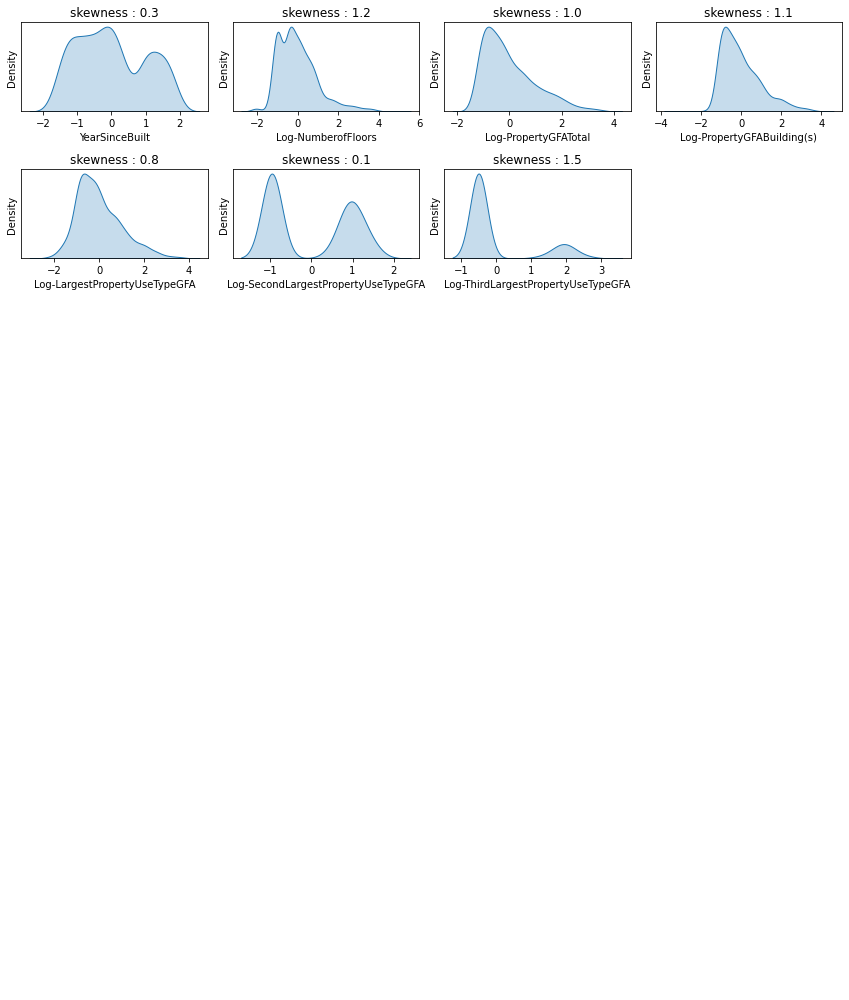

In [410]:
print("We can check that the numerical variables have a Standard Normal distribution.")
density(train_energy_preprocess[numerical_columns_energy_CO2])

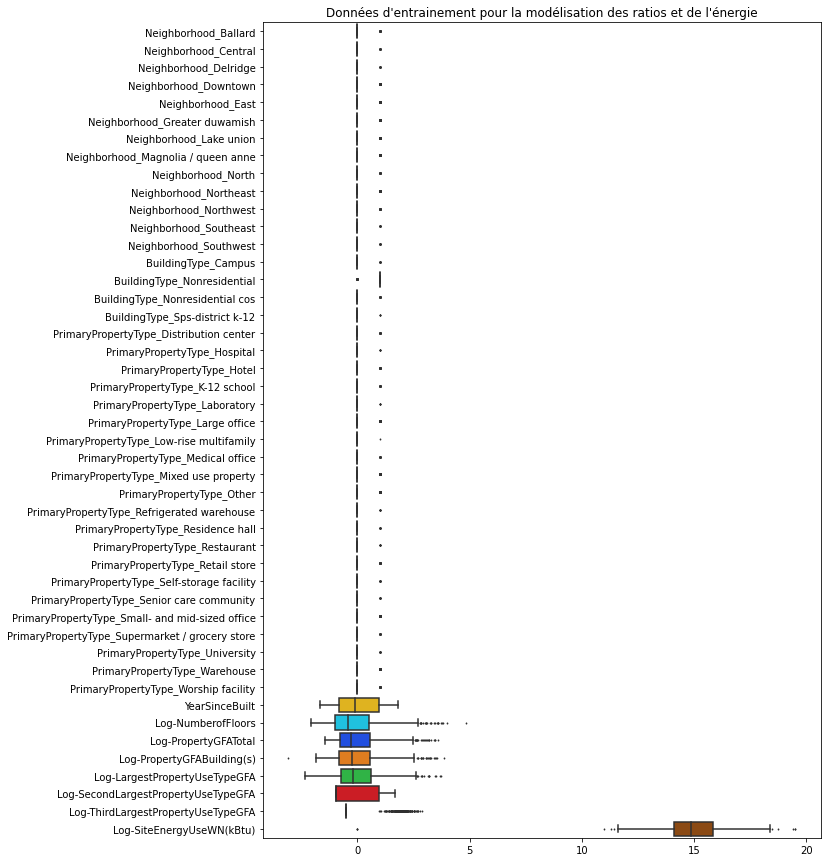

In [411]:
# Distribution des variables du jeu d'entrainement
plt.figure(figsize=(10,15))
plt.title('Données d\'entrainement pour la modélisation des ratios et de l\'énergie')
bp = sns.boxplot(x='value', y='variable', data=pd.melt(train_energy_preprocess), palette='bright',
                 flierprops=dict(markersize=1, markerfacecolor='gray'))
bp.set_xlabel("")
bp.set_ylabel("")
plt.show()

We can check that the numerical variables have a Standard Normal distribution.
___Density distribution___


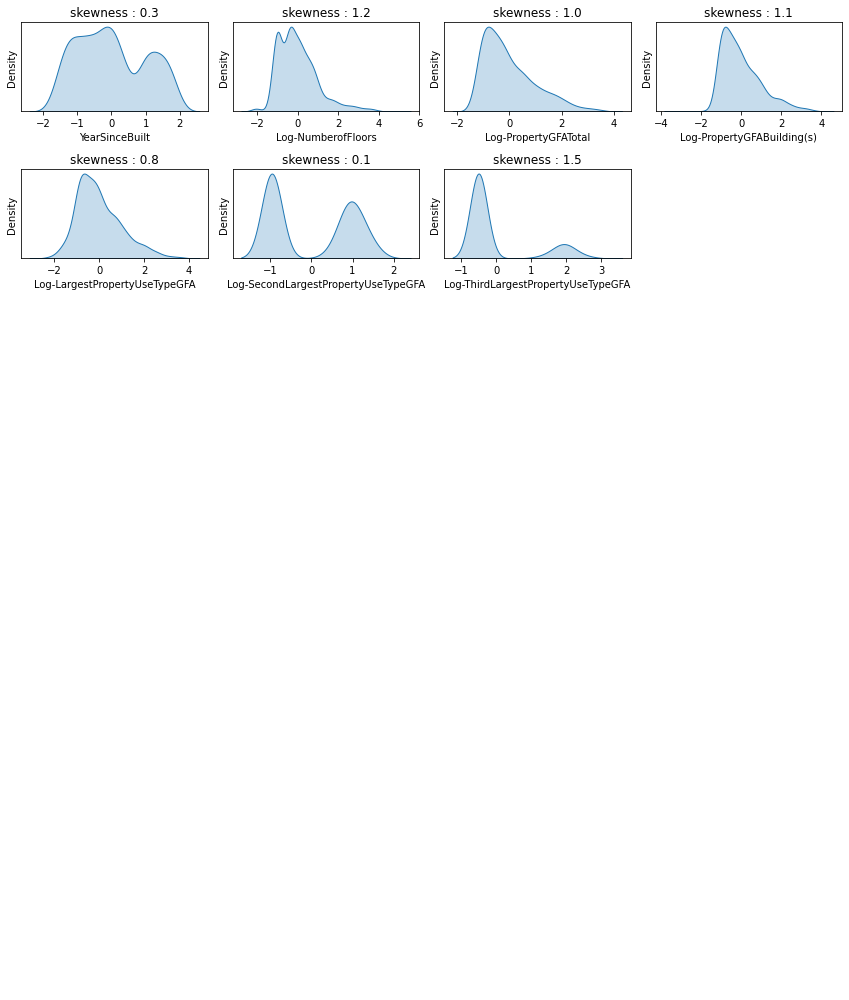

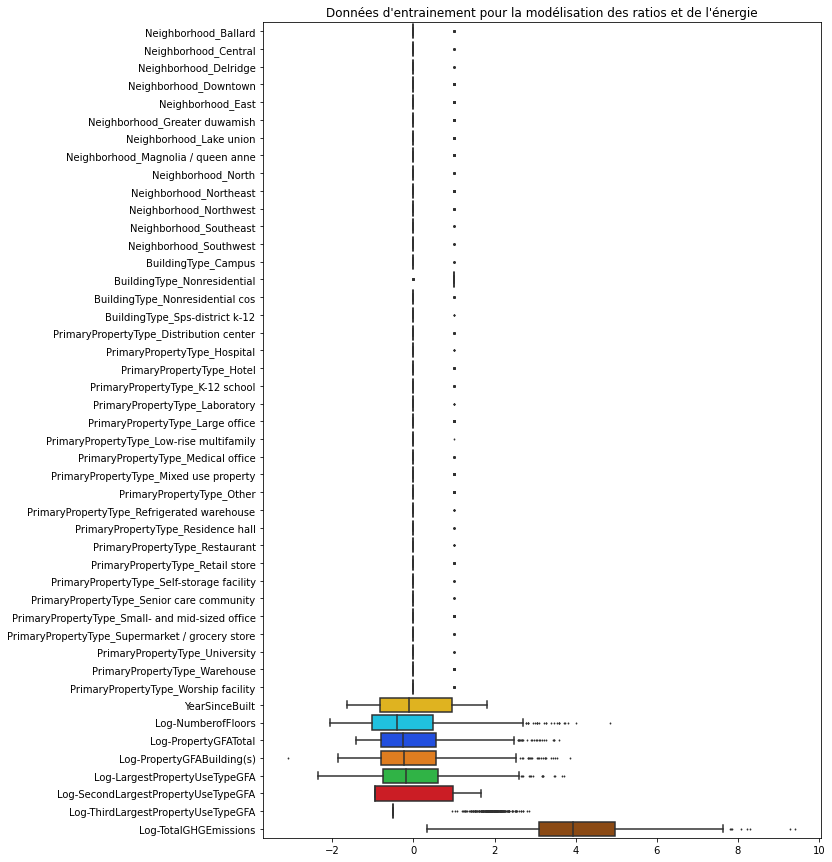

In [412]:
print("We can check that the numerical variables have a Standard Normal distribution.")
density(train_CO2_preprocess[numerical_columns_energy_CO2])

# Distribution des variables du jeu d'entrainement
plt.figure(figsize=(10,15))
plt.title('Données d\'entrainement pour la modélisation des ratios et de l\'énergie')
bp = sns.boxplot(x='value', y='variable', data=pd.melt(train_CO2_preprocess), palette='bright',
                 flierprops=dict(markersize=1, markerfacecolor='gray'))
bp.set_xlabel("")
bp.set_ylabel("")
plt.show()

##### ENERGYSTARScore

We can check that the numerical variables have a Standard Normal distribution.
___Density distribution___


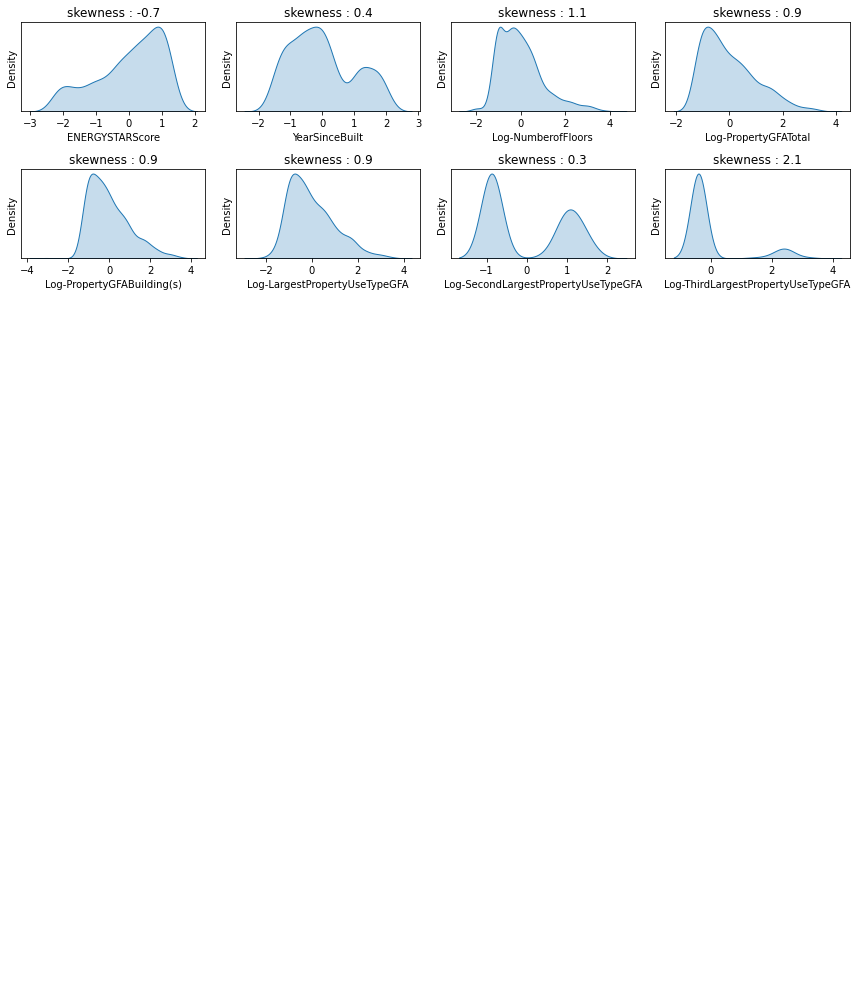

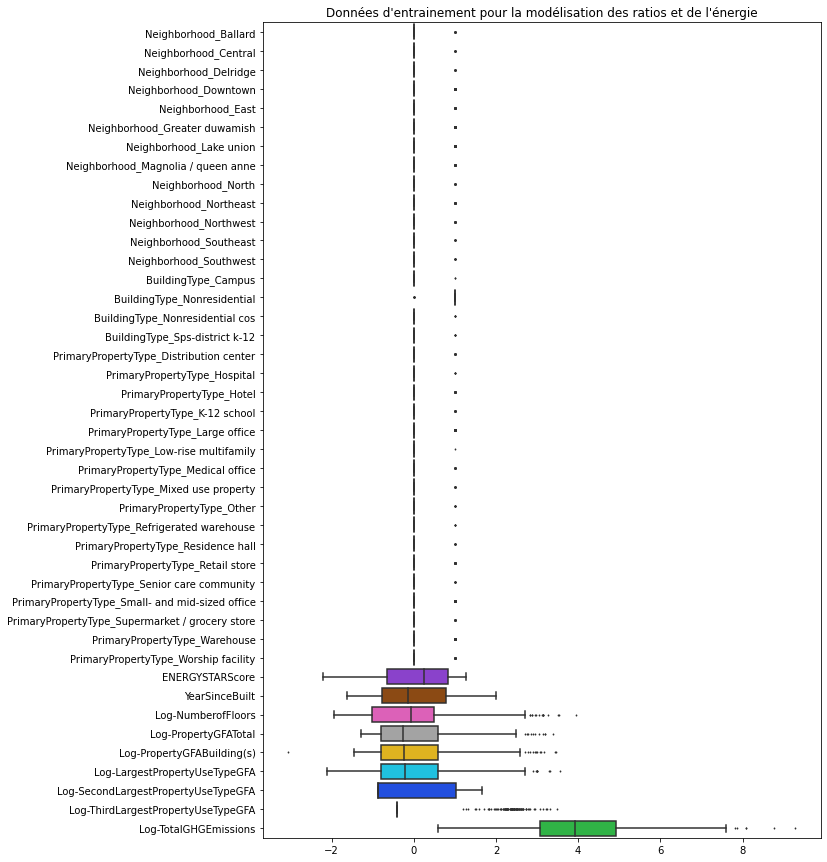

In [413]:
print("We can check that the numerical variables have a Standard Normal distribution.")
density(train_ENERGYSTARScore_preprocess[numerical_columns_ENERGYSTARScore])

# Distribution des variables du jeu d'entrainement
plt.figure(figsize=(10,15))
plt.title('Données d\'entrainement pour la modélisation des ratios et de l\'énergie')
bp = sns.boxplot(x='value', y='variable', data=pd.melt(train_ENERGYSTARScore_preprocess), palette='bright',
                 flierprops=dict(markersize=1, markerfacecolor='gray'))
bp.set_xlabel("")
bp.set_ylabel("")
plt.show()

#### 4) Saving dataset

In [414]:
path_save_energy = "./dataset/energy/"
path_save_CO2 = "./dataset/CO2/"
path_save_ENERGYSTARScore = "./dataset/CO2_ENERGYSTARScore/"

##### Energy

In [415]:
# Sauvegarde des jeux de données
train_energy_preprocess.to_csv("{}{}".format(path_save_energy, "train_energy.csv"), encoding='utf-8', index=False)
test_energy_preprocess.to_csv("{}{}".format(path_save_energy, "test_energy.csv"), encoding='utf-8', index=False)

# Sauvegarde du modèle pour standardiser
model = {'scaler': std_scaler_energy, 'scaler_features': numerical_columns_energy_CO2.tolist(), 'encoder': one_hot_encoder, 'encoder_features': categorical_columns.tolist()}
filename = './model/preprocessing/scaler_encoder_energy.sav'
pickle.dump(model, open(filename, 'wb'))

In [416]:
train_energy_preprocess

,Neighborhood_Ballard,Neighborhood_Central,Neighborhood_Delridge,Neighborhood_Downtown,Neighborhood_East,Neighborhood_Greater duwamish,Neighborhood_Lake union,Neighborhood_Magnolia / queen anne,Neighborhood_North,Neighborhood_Northeast,...,PrimaryPropertyType_Warehouse,PrimaryPropertyType_Worship facility,YearSinceBuilt,Log-NumberofFloors,Log-PropertyGFATotal,Log-PropertyGFABuilding(s),Log-LargestPropertyUseTypeGFA,Log-SecondLargestPropertyUseTypeGFA,Log-ThirdLargestPropertyUseTypeGFA,Log-SiteEnergyUseWN(kBtu)
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.009588,1.789163,0.380914,0.496952,0.592599,-0.959144,-0.506127,15.824652
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-1.073960,1.669206,0.549649,0.497818,0.536131,0.985881,1.841900,15.974742
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-0.258658,3.546677,2.924050,2.918469,2.885175,-0.959144,-0.506127,18.118725
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-0.590818,2.357891,1.113570,0.778771,0.948845,1.290628,-0.506127,16.500395
5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-1.164549,-0.408384,0.482847,0.061798,0.597371,-0.959144,-0.506127,16.347755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1503,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.949196,-0.408384,-0.969118,-0.926228,-0.757201,-0.959144,-0.506127,15.369819
1504,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,-1.587298,-1.016040,0.161290,0.265429,0.373013,-0.959144,-0.506127,14.978305
1505,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-1.647690,0.022755,-0.340793,-0.263859,-0.111843,-0.959144,-0.506127,14.150370
1506,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,-1.647690,0.861431,1.836029,1.712552,1.167740,1.381303,2.648748,17.530998


##### CO2

In [417]:
# Sauvegarde des jeux de données
train_CO2_preprocess.to_csv("{}{}".format(path_save_CO2, "train_CO2.csv"), encoding='utf-8', index=False)
test_CO2_preprocess.to_csv("{}{}".format(path_save_CO2, "test_CO2.csv"), encoding='utf-8', index=False)

# Sauvegarde du modèle pour standardiser
model = {'scaler': std_scaler_CO2, 'scaler_features': numerical_columns_energy_CO2.tolist(), 'encoder': one_hot_encoder, 'encoder_features': categorical_columns.tolist()}
filename = './model/preprocessing/scaler_encoder_CO2.sav'
pickle.dump(model, open(filename, 'wb'))

display(train_CO2_preprocess)

,Neighborhood_Ballard,Neighborhood_Central,Neighborhood_Delridge,Neighborhood_Downtown,Neighborhood_East,Neighborhood_Greater duwamish,Neighborhood_Lake union,Neighborhood_Magnolia / queen anne,Neighborhood_North,Neighborhood_Northeast,...,PrimaryPropertyType_Warehouse,PrimaryPropertyType_Worship facility,YearSinceBuilt,Log-NumberofFloors,Log-PropertyGFATotal,Log-PropertyGFABuilding(s),Log-LargestPropertyUseTypeGFA,Log-SecondLargestPropertyUseTypeGFA,Log-ThirdLargestPropertyUseTypeGFA,Log-TotalGHGEmissions
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.009588,1.789163,0.380914,0.496952,0.592599,-0.959144,-0.506127,5.525373
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-1.073960,1.669206,0.549649,0.497818,0.536131,0.985881,1.841900,5.693261
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-0.258658,3.546677,2.924050,2.918469,2.885175,-0.959144,-0.506127,7.645053
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-0.590818,2.357891,1.113570,0.778771,0.948845,1.290628,-0.506127,6.226556
5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-1.164549,-0.408384,0.482847,0.061798,0.597371,-0.959144,-0.506127,5.713106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1503,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.949196,-0.408384,-0.969118,-0.926228,-0.757201,-0.959144,-0.506127,4.911183
1504,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,-1.587298,-1.016040,0.161290,0.265429,0.373013,-0.959144,-0.506127,4.229021
1505,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-1.647690,0.022755,-0.340793,-0.263859,-0.111843,-0.959144,-0.506127,2.326302
1506,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,-1.647690,0.861431,1.836029,1.712552,1.167740,1.381303,2.648748,6.908815


##### ENERGYSTARScore

In [418]:
# Sauvegarde des jeux de données
train_ENERGYSTARScore_preprocess.to_csv("{}{}".format(path_save_ENERGYSTARScore, "train_ENERGYSTARScore.csv"), encoding='utf-8', index=False)
test_ENERGYSTARScore_preprocess.to_csv("{}{}".format(path_save_ENERGYSTARScore, "test_ENERGYSTARScore.csv"), encoding='utf-8', index=False)

# Sauvegarde du modèle pour standardiser
model = {'scaler': std_scaler_ENERGYSTARScore, 'scaler_features': numerical_columns_ENERGYSTARScore.tolist(), 'encoder': one_hot_encoder, 'encoder_features': categorical_columns.tolist()}
filename = './model/preprocessing/scaler_encoder_ENERGYSTARScore.sav'
pickle.dump(model, open(filename, 'wb'))

display(train_ENERGYSTARScore_preprocess)

,Neighborhood_Ballard,Neighborhood_Central,Neighborhood_Delridge,Neighborhood_Downtown,Neighborhood_East,Neighborhood_Greater duwamish,Neighborhood_Lake union,Neighborhood_Magnolia / queen anne,Neighborhood_North,Neighborhood_Northeast,...,PrimaryPropertyType_Worship facility,ENERGYSTARScore,YearSinceBuilt,Log-NumberofFloors,Log-PropertyGFATotal,Log-PropertyGFABuilding(s),Log-LargestPropertyUseTypeGFA,Log-SecondLargestPropertyUseTypeGFA,Log-ThirdLargestPropertyUseTypeGFA,Log-TotalGHGEmissions
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.140254,1.137752,1.527129,0.239730,0.350556,0.419223,-0.876198,-0.412006,5.525373
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.105292,-1.035230,1.418549,0.400642,0.351378,0.363099,1.025778,2.183978,5.693261
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.384177,-0.531350,2.041912,0.938421,0.618379,0.773302,1.323780,-0.412006,6.226556
6,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-1.294003,1.169244,1.418549,0.175224,0.282790,0.330612,-0.876198,-0.412006,5.176940
9,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-1.189116,-0.184933,1.418549,0.799269,0.794395,0.859479,-0.876198,-0.412006,6.539962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1489,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.174404,-1.507617,-1.952265,0.334337,0.449943,0.517809,-0.876198,-0.412006,4.149622
1496,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.223267,-1.602095,1.527129,1.964454,1.718344,1.854752,1.461654,-0.412006,4.998158
1502,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,-0.944382,0.255962,-1.012000,-0.299567,-0.306464,-0.142752,-0.876198,-0.412006,5.067016
1503,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,-1.923320,1.074767,-0.461980,-1.047717,-1.001952,-0.922362,-0.876198,-0.412006,4.911183


In [419]:
t1 = time()
print("computing time : {:8.6f} sec".format(t1-t0))
print("computing time : " + strftime('%H:%M:%S', gmtime(t1-t0)))

computing time : 9.226419 sec
computing time : 00:00:09
